In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiskit
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from hybrid_nn import HybridNNModel, QuantumCircuit, Net, MyDataset

Expected value for rotation pi 0.52


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


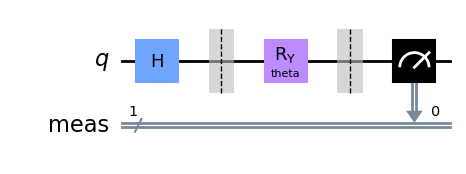

In [101]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw(output='mpl')


In [107]:
dataset_name = 'vlds_1k'
df = pd.read_csv(f'datasets/{dataset_name}.csv', index_col=0)
feature_dimension = df.shape[1] - 1

all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=0.75, random_state=42)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

test_loader = torch.utils.data.DataLoader(MyDataset(test_features, test_labels), batch_size=1, shuffle=True)

In [108]:
folds = 10
epochs = 10
models = [
        HybridNNModel(
            Net(feature_dimension=feature_dimension, backend=simulator),
            fold=fold,
            loss_func=nn.NLLLoss,
            epochs=epochs,
            dataset_name=dataset_name
        ) for fold in range(folds)
    ]

map(lambda model: model.load(), models)

/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Fold 0 accuracy 51.20%, trained in 0.00000 seconds
Fold 1 accuracy 51.20%, trained in 0.00000 seconds
Fold 2 accuracy 64.80%, trained in 0.00000 seconds
Fold 3 accuracy 34.00%, trained in 0.00000 seconds
Fold 4 accuracy 22.80%, trained in 0.00000 seconds
Fold 5 accuracy 34.40%, trained in 0.00000 seconds
Fold 6 accuracy 67.20%, trained in 0.00000 seconds
Fold 7 accuracy 30.40%, trained in 0.00000 seconds
Fold 8 accuracy 63.20%, trained in 0.00000 seconds
Fold 9 accuracy 65.60%, trained in 0.00000 seconds
Accuracy mean: 48.480000000000004%, std: 15.923617679409412


{'whiskers': [<matplotlib.lines.Line2D at 0x17e34b6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2aa2aec10>,
 'boxes': [<matplotlib.lines.Line2D at 0x17e3579d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2a57fa640>],
 'fliers': [<matplotlib.lines.Line2D at 0x2abc8f6a0>],
 'means': []}

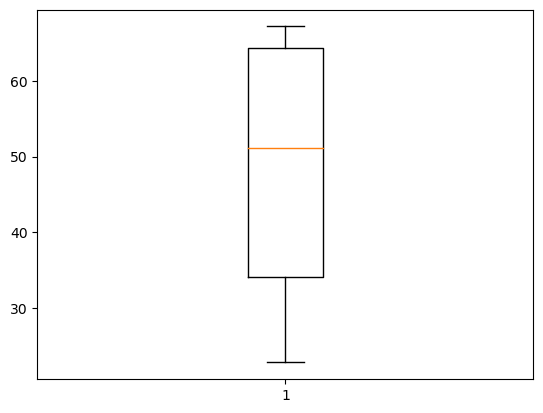

In [109]:
accuracies = np.array([model.score(test_loader) for model in models])
for i, model in enumerate(models):
    print('Fold %d accuracy %.2f%%' % (i+1, accuracies[i]))
print(f"Accuracy mean: {accuracies.mean()}%, std: {accuracies.std()}")
plt.boxplot(accuracies)

In [110]:
models[9].model.hybrid.quantum_circuit.backend


AerSimulator('aer_simulator')

In [ ]:
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ

# Best kernel should already be evaluated and set (in the above code cell)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='zhaw-1')
backend = least_busy(provider.backends(simulator=True))
print(f"Chosen backend: {backend}")
models[9].model.hybrid.quantum_circuit.backend = backend
models[9].score(test_loader)


ibmqfactory.load_account:WARNING:2023-01-11 23:48:59,884: Credentials are already in use. The existing account in the session will be replaced.


Chosen backend: ibmq_qasm_simulator


/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukas/miniforge3/envs/qc/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
